# Homework 4 - Question 2

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm          #Used for the purpose of showing iterations getting loaded in bar kind of form
from random import shuffle
from zipfile import ZipFile
import glob
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os

In [8]:
#return any files with .zip extension
zip_file = glob.glob('/content/gdrive/MyDrive/Colab/datasets/*.zip')
print(zip_file)

['/content/gdrive/MyDrive/Colab/datasets/test.zip', '/content/gdrive/MyDrive/Colab/datasets/train.zip']


In [ ]:
!unzip /content/gdrive/MyDrive/Colab/datasets/test.zip -d /content/gdrive/MyDrive/Colab/datasets/Catdogs/

In [13]:
!unzip /content/gdrive/MyDrive/Colab/datasets/train.zip -d /content/gdrive/MyDrive/Colab/datasets/Catdogs/

Streaming output truncated to the last 5000 lines.
  inflating: /content/gdrive/MyDrive/Colab/datasets/Catdogs/train/dog.5499.jpg  
  inflating: /content/gdrive/MyDrive/Colab/datasets/Catdogs/train/dog.55.jpg  
  inflating: /content/gdrive/MyDrive/Colab/datasets/Catdogs/train/dog.550.jpg  
  inflating: /content/gdrive/MyDrive/Colab/datasets/Catdogs/train/dog.5500.jpg  
  inflating: /content/gdrive/MyDrive/Colab/datasets/Catdogs/train/dog.5501.jpg  
  inflating: /content/gdrive/MyDrive/Colab/datasets/Catdogs/train/dog.5502.jpg  
  inflating: /content/gdrive/MyDrive/Colab/datasets/Catdogs/train/dog.5503.jpg  
  inflating: /content/gdrive/MyDrive/Colab/datasets/Catdogs/train/dog.5504.jpg  
  inflating: /content/gdrive/MyDrive/Colab/datasets/Catdogs/train/dog.5505.jpg  
  inflating: /content/gdrive/MyDrive/Colab/datasets/Catdogs/train/dog.5506.jpg  
  inflating: /content/gdrive/MyDrive/Colab/datasets/Catdogs/train/dog.5507.jpg  
  inflating: /content/gdrive/MyDrive/Colab/datasets/Catdogs/t

In [14]:
TrainPath='/content/gdrive/MyDrive/Colab/datasets/Catdogs/train'
TestPath='/content/gdrive/MyDrive/Colab/datasets/Catdogs/test'

In [10]:
# extract file into a temp folder
def extract_zip(file):
  with ZipFile(file,'r') as zip_ref:
    zip_ref.extractall('/content/gdrive/MyDrive/Colab/datasets/Zips/')
#extract both train and test zip
for files in zip_file:
  extract_zip(files)

KeyboardInterrupt: ignored

In [15]:
def get_path(directory):
    path = []
    for files in os.listdir(directory):
        path.append(files)
    return path
train_path = get_path(TrainPath)
test_path = get_path(TestPath)

In [16]:
# Preparing data for visualization

#this labelling function is just for the visualization, we'll have separate one for preprocessing.
def label_img(img):
    category = img.split('.')[-3]
    if category == 'cat': return [1,0]
    elif category == 'dog': return [0,1]

#Process the data, here we're converting images into numpy array. This function takes image data, image directory, a boolean as an argument.
def process_data(img_data, data_dir, isTrain=True):
    data_df = []
    for img in tqdm(img_data):
        path = os.path.join(data_dir,img)         #Assigning path to images by concatenating directory and images
        if(isTrain):
          label = label_img(img)            #Calling label_img to assign labels to image present in training directory
        else:
            label = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224,224))
        data_df.append([np.array(img),np.array(label)])          #append image and labels as numpy array in data_df list
    shuffle(data_df)
    return data_df
#We will plot the images of dogs and cats and display the assigned label above image
def show_images(data, isTest=False):
    f, ax = plt.subplots(nrows = 5, ncols = 5, figsize = (15,15))
    for i,data in enumerate(data[:25]):              #enumerate helps in keeping track of count of iterations
        img_num = data[1]
        img_data = data[0]
        label = np.argmax(img_num)                    #to get maximum indices of an array
        if label  == 1: 
            str_label='Dog'
        elif label == 0: 
            str_label='Cat'
        if(isTest):
            str_label="None"
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis('off')                 #removing axis for better look
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
    plt.show()

100%|██████████| 25000/25000 [02:03<00:00, 202.33it/s]


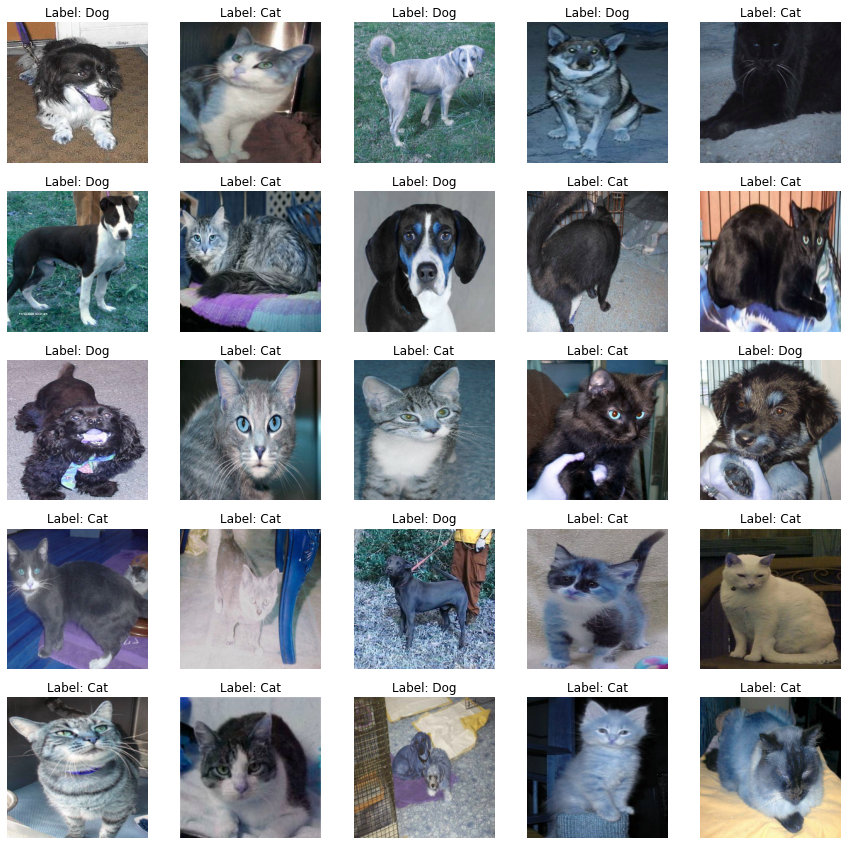

In [57]:
train = process_data(train_path, TrainPath)
show_images(train)

100%|██████████| 12500/12500 [01:01<00:00, 202.50it/s]


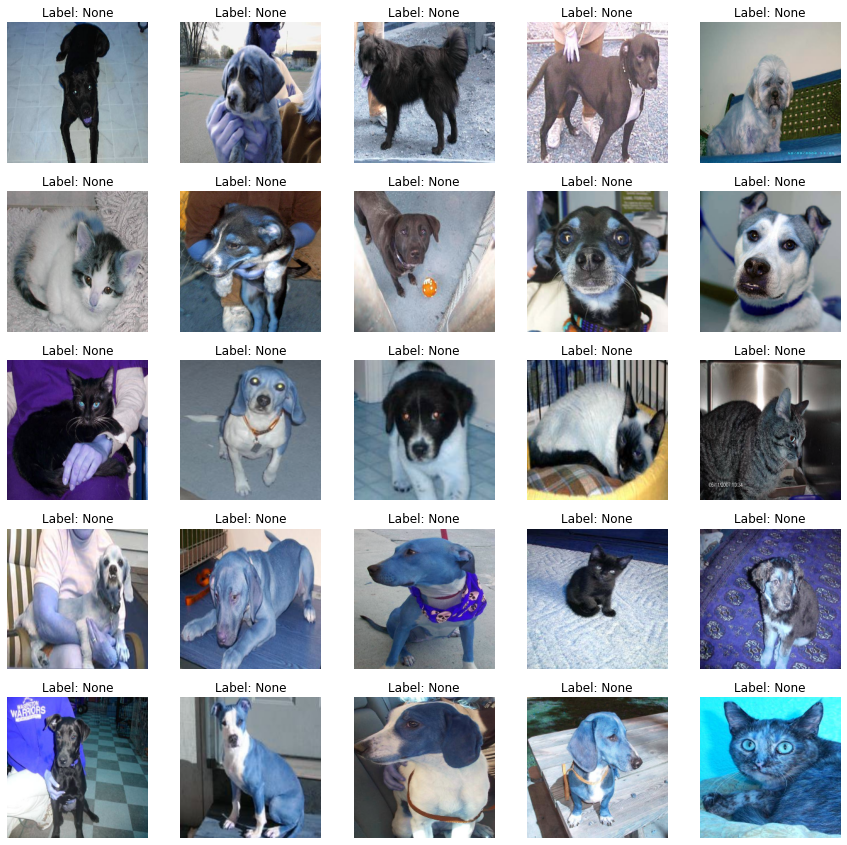

In [ ]:
test = process_data(test_path, TestPath, False)
show_images(test,True)

### Step1: Data Preprocessing

-	Generate labels, if the picture is dog, then assign a value “1”, if the picture is cat, then assign a value of “0”  
-	Convert image and labels into dataframe

In [17]:
#Convert Data to DataFrame
def get_label(directory):
  label = []
  for file in os.listdir(directory):
    if (file.split('.')[0]=='dog'):
      label.append(str(1))
    elif (file.split('.')[0]=='cat'):
      label.append(str(0))
  return label
label = get_label(TrainPath)
df=pd.DataFrame({'filename':train_path,'label':label})
df.head()

filename label
0     cat.0.jpg     0
1     cat.1.jpg     0
2    cat.10.jpg     0
3   cat.100.jpg     0
4  cat.1000.jpg     0

-	Train test split with 20% test data and 80% traning data

In [18]:
# train test split
train_df,valid_df = train_test_split(df,test_size=0.2,stratify = df['label'],random_state=123)
print(train_df.shape)
print(valid_df.shape)

(20000, 2)
(5000, 2)


-	Generate mini batches for training to improve performance

In [19]:
#Generating mini batches for training
#We'll perform individually on train and validation set.
train_datagen = ImageDataGenerator(rotation_range = 10, zoom_range = 0.1, horizontal_flip = True, fill_mode = 'nearest', 
                                   width_shift_range = 0.1, height_shift_range = 0.1, preprocessing_function = preprocess_input)

#flow_from_dataframe() method will accept dataframe with filenames as x_column and labels as y_column to generate mini-batches
train_gen = train_datagen.flow_from_dataframe(train_df, directory = TrainPath, x_col = 'filename', y_col = 'label', target_size = (224,224),
                                              batch_size = 64, class_mode='binary')

#we do not augment validation data.
valid_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

valid_gen = valid_datagen.flow_from_dataframe(valid_df, directory = TrainPath, x_col = 'filename', y_col = 'label', target_size = (224,224),
                                              batch_size = 64, class_mode='binary')

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


### Step2: Modeling

In [32]:
#Modeling
model = Sequential()
model.add(ResNet50(include_top = False, pooling = 'max', weights = 'imagenet'))
model.add(Dense(1, activation = 'sigmoid'))
model.layers[0].trainable = False 

#Model Summary
model.summary()
# Compile Model
model.compile(optimizer = 'adam', metrics = ['accuracy'], loss = 'binary_crossentropy')
# Callback
checkpointer = ModelCheckpoint(filepath = 'dogcat.weights.best.hdf5', save_best_only = True, save_weights_only = True)
# Train Model
model.fit_generator(train_gen, epochs = 10, validation_data = valid_gen, callbacks = [checkpointer])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
313/313 [==============================] - 330s 1s/step - loss: 0.5669 - accuracy: 0.8885 - val_loss: 0.0728 - val_accuracy: 0.9854
Epoch 2/10
313/313 [==============================] - 326s 1s/step - loss: 0.1026 - accuracy: 0.9771 - val_loss: 0.0848 - val_accuracy: 0.9846
Epoch 3/10
313/313 [==============================] - 327s 1s/step - loss: 0.0730 - accuracy: 0.9848 - val_loss: 0.0824 - val_accuracy: 0.9844
Epoch 4/10
313/313 [==============================] - 325s 1s/step - loss: 0.0716 - accuracy: 0.9847 - val_loss: 0.0952 - val_accuracy: 0.9844
Epoch 5/10
313/313 [==============================] - 326s 1s/step - loss: 0.0709 - accuracy: 0.9857 - val_loss: 0.1210 - val_accuracy: 0.9816
Epoch 6/10
313/313 [==============================] - 329s 1s/step - loss: 0.0664 - accuracy: 0.9865 - val_loss: 0.0708 - val_accuracy: 0.9872
Epoch 7/10
313/313 [==============================] - 324s 1s/step - loss: 0.0706 - accuracy: 0.9870 - val_loss: 0.1144 - val_accuracy: 0.9814

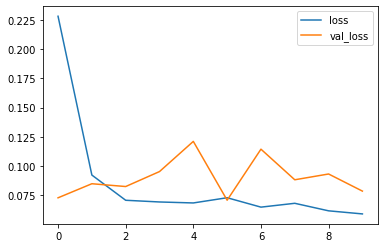

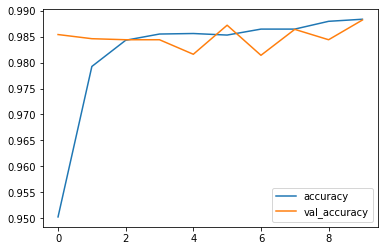

In [33]:
loss = pd.DataFrame(model.history.history)
loss[['loss','val_loss']].plot()
loss[['accuracy','val_accuracy']].plot()

### Step3: Prediction

In [34]:
# Results
model.load_weights('dogcat.weights.best.hdf5')
test_df = pd.DataFrame({'filename':test_path})

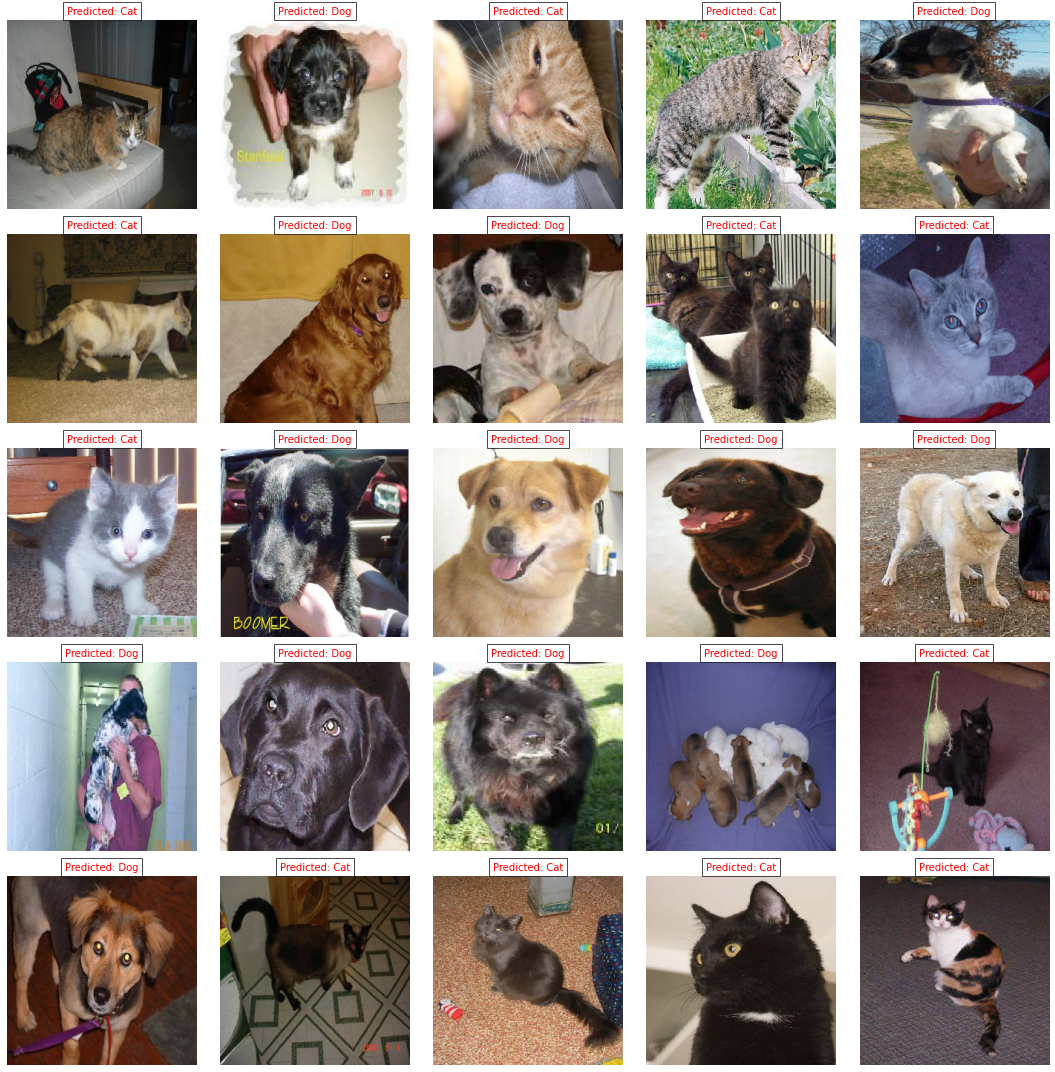

In [35]:
#Visualize Predictions 
TestPath='/content/gdrive/MyDrive/Colab/datasets/Catdogs/test/'
test_sample = test_df.sample(n=25,random_state  = 123)
label_pred = []
for path in test_sample['filename'].to_numpy():
  full_path = TestPath+path 
  x = load_img(full_path,target_size = (224,224))
  img_array = img_to_array(x)
  img_array = np.expand_dims(img_array,axis=0)

  out = model.predict(img_array)
  out = 'Dog' if float(out)>0.5 else 'Cat'
  label_pred.append(out)

test_array = test_sample['filename'].to_numpy()            # convert dataframe to numpy array 
# We will plot 25 random test images with their class using list of predicted labels.
plt.figure(figsize=(15, 15))
for i in range(0, 25):
    plt.subplot(5, 5, i+1)
    img = test_array[i]
    path = TestPath + img
    image = load_img(path, target_size=(256,256))
    
    plt.title('Predicted: {}'.format(label_pred[i]), color='red',fontsize= 10, bbox=dict(facecolor='white', alpha=0.7))
    plt.imshow(image)
    plt.axis('off')
plt.tight_layout()

In [36]:
#Generate Mini Batches of test data
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
test_gen = test_datagen.flow_from_dataframe(test_df,directory = TestPath,
                                            batch_size = 64,x_col = 'filename',y_col = None, class_mode = None,shuffle = False,
                                            img_size=(224,224))

Found 12500 validated image filenames.


In [37]:
prediction = model.predict_generator(test_gen)
prediction = prediction.clip(min = 0.005, max = 0.995)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


### Step4: Submit

In [38]:
#Submission File
submission_df = pd.read_csv('/content/gdrive/MyDrive/Colab/datasets/sample_submission.csv')
for i ,fname in enumerate(test_path):
  index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
  submission_df.at[index-1,'label'] = prediction[i]
submission_df.head()

id  label
0   1  0.995
1   2  0.995
2   3  0.995
3   4  0.995
4   5  0.005

In [41]:
from google.colab import files
submission_df.to_csv('MSBA.Session2.XiaowenTang.csv',index=False)
files.download('MSBA.Session2.XiaowenTang.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>